#### CSC 215 Artificial Intelligence (Spring 2023)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Lab 19:  Implementing cGAN using GradientTape


# Conditional GAN

Generative adversarial nets can be extended to a [conditional GAN model](https://arxiv.org/pdf/1411.1784.pdf) if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

* **Generator**: The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

* **Discriminator**: $x$ and $y$ are presented as inputs and to a discriminative function.

### Network Design

<img src="https://github.com/mafda/generative_adversarial_networks_101/blob/master/img/network_design_ccgan_cifar.png?raw=1" width="600"> 


### Cost Funcion

$$ \underset{G}{min} \: \underset{D}{max} \; V_{CGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$


In this lab, we'll build a **Conditional GAN that can generate MNIST handwritten
digits conditioned on a given class**. Such a model can have various useful applications:

* let's say you are dealing with an
[imbalanced image dataset](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data),
and you'd like to gather more examples for the skewed class to balance the dataset. You could ***train a Conditional GAN and use
it to generate data for the class that needs balancing***.
* Since the generator learns to associate the generated samples with the class labels,
its representations can also be used for [other downstream tasks](https://arxiv.org/abs/1809.11096).

#### This lab shows you how to train a Conditional GAN using (1) GradientTape() and (2) [train_on_batch()](https://keras.io/api/models/model_training_apis/), respectively. 

# Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import tensorflow
import tensorflow as tf
print (tensorflow.__version__)

2.9.2


# Download and show data

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


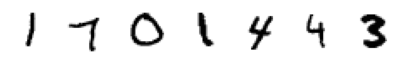

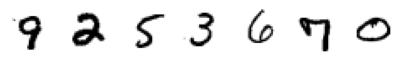

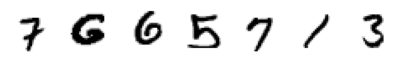

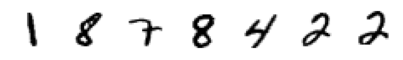

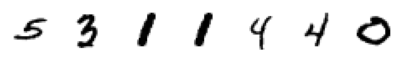

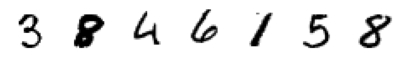

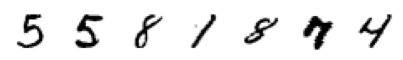

In [ ]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(7):
    plt.figure(figsize=(7, 7))
    for j in range(7):
        i = np.random.randint(0, 10000)
        plt.subplot(770 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
    plt.show()

# data normalization

In [ ]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [ ]:
random_input = tensorflow.keras.layers.Input(shape = 100)
class_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(5*5*4)(random_input)
x1 = tensorflow.keras.layers.Activation('relu')(x1)
x1 = tensorflow.keras.layers.Reshape((5, 5, 4))(x1)

#Class Input
x2 = tensorflow.keras.layers.Dense(25)(class_input)
x2 = tensorflow.keras.layers.Activation('relu')(x2)
x2 = tensorflow.keras.layers.Reshape((5, 5, 1))(x2)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, class_input], outputs=generated_image)


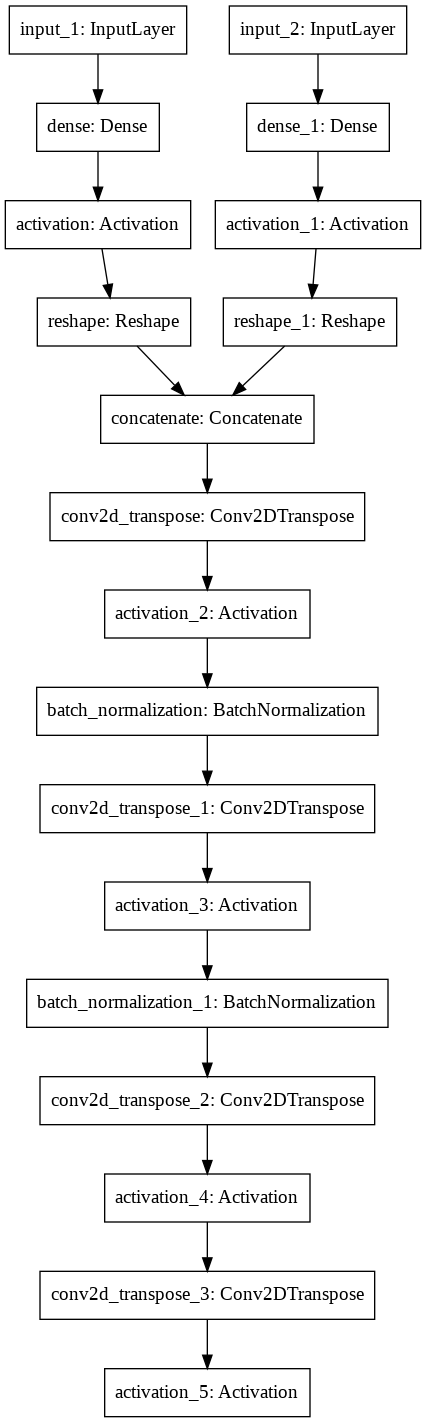

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(generator_network , to_file='model.png', show_shapes=True)

# Define Discriminator

In [ ]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))
class_input = tensorflow.keras.layers.Input(shape = 10)

#Class Input
x2 = tensorflow.keras.layers.Dense(28*28)(class_input)
x2 = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x2)
x2 = tensorflow.keras.layers.Reshape((28, 28, 1))(x2)

x = tensorflow.keras.layers.Concatenate()([image_input, x2])

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(1)(x)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[image_input, class_input], outputs=real_vs_fake_output)


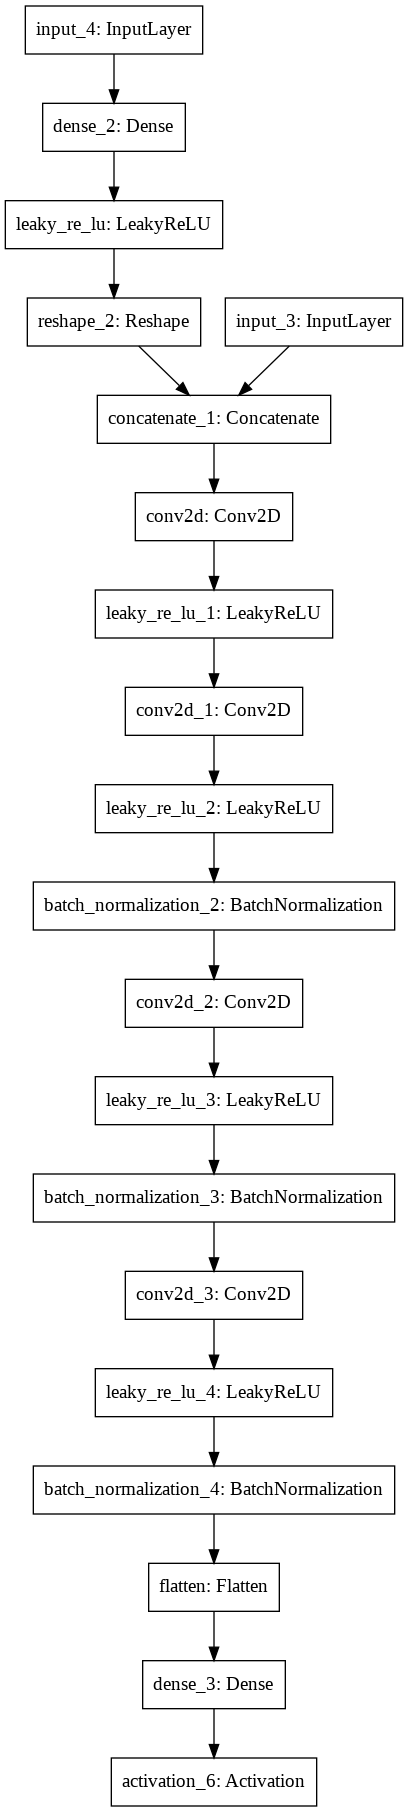

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(discriminator_network, to_file='model.png', show_shapes=True)

The following commented code is only needed if you use [train_on_batch()](https://keras.io/api/models/model_training_apis/)

In [ ]:
#adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
#discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [ ]:
# define combined model: CGAN

#  By setting trainable=False after the discriminator has been compiled 
#the discriminator is still trained during discriminator.train_on_batch 
#but since it's set to non-trainable before the combined model is compiled 
#it's not trained during combined.train_on_batch.

#discriminator_network.trainable=False
#gan_input = generator_network([random_input, class_input])
#gan_output = discriminator_network([gan_input, class_input])

#gan_model = tensorflow.keras.models.Model([random_input, class_input], gan_output)


In [ ]:
# compiling CGAN
#adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
#gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Utility Functions

In [ ]:
indices = [i for i in range(0, len(trainX))]

def encode_class(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_class(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    class_names = []
    for i in range(batch_size):
        class_name = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        class_names.append(encode_class(class_name))
    class_names = np.array(class_names)
    return random_noise_batches, class_names

def get_fake_samples(generator_network, batch_size, noise_size, class_name=-1):
    random_noise_batches, _ = get_random_noise(batch_size, noise_size) 
    if class_name == -1:
        class_names = []
        for i in range(batch_size):
            class_name = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
            class_names.append(encode_class(class_name))
        class_names = np.array(class_names)
    else:
        class_names = []
        for i in range(batch_size):
            class_names.append(encode_class(class_name))
        class_names = np.array(class_names)
           
    fake_samples = generator_network.predict_on_batch([random_noise_batches, class_names])
    return [fake_samples, class_names]

def get_real_samples(batch_size, class_names=-1):
    if class_names == -1:
        random_indices = np.random.choice(indices, size=batch_size)
        class_names = []
        for ind in random_indices:
            class_names.append(encode_class(trainY[ind]))
        
    else:
        random_indices = []
        for cls in class_names:
            ind = np.random.choice(np.where(trainY==cls), size=1)
            random_indices.append(ind)

    real_images = trainX[np.array(random_indices),:]
    return [real_images, class_names]

def show_generator_results(generator_network):
    for k in range(10):
        fake_samples = get_fake_samples(generator_network, 10, noise_size, k)
        plt.figure(figsize=(10, 6))
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[0][i,:,:,-1], cmap='gray_r')
            #plt.title(decode_class(fake_samples[1][i]))
            plt.axis('off')
        plt.show()
    return

# Training CGAN 

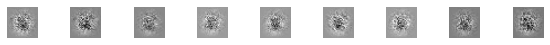

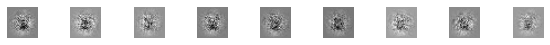

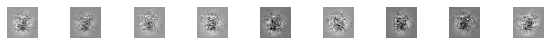

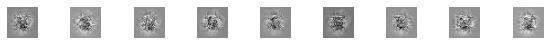

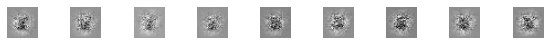

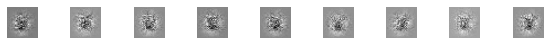

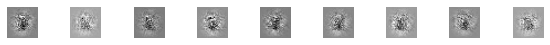

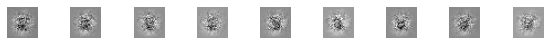

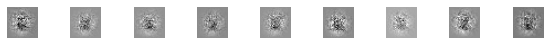

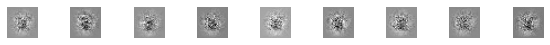

Epoch:0, Step:0, D-Loss:0.691, G-Loss:0.694
Epoch:0, Step:50, D-Loss:0.681, G-Loss:0.700
Epoch:0, Step:100, D-Loss:0.698, G-Loss:0.683
Epoch:0, Step:150, D-Loss:0.671, G-Loss:0.685
Epoch:0, Step:200, D-Loss:0.680, G-Loss:0.733
Epoch:0, Step:250, D-Loss:0.689, G-Loss:0.730
Epoch:0, Step:300, D-Loss:0.710, G-Loss:0.666
Epoch:0, Step:350, D-Loss:0.754, G-Loss:0.614
Epoch:0, Step:400, D-Loss:0.678, G-Loss:0.767
Epoch:0, Step:450, D-Loss:0.702, G-Loss:0.672
Epoch:1, Step:0, D-Loss:0.671, G-Loss:0.730
Epoch:1, Step:50, D-Loss:0.692, G-Loss:0.703
Epoch:1, Step:100, D-Loss:0.656, G-Loss:0.818
Epoch:1, Step:150, D-Loss:0.811, G-Loss:0.529
Epoch:1, Step:200, D-Loss:0.696, G-Loss:0.667
Epoch:1, Step:250, D-Loss:0.714, G-Loss:0.687
Epoch:1, Step:300, D-Loss:0.727, G-Loss:0.673
Epoch:1, Step:350, D-Loss:0.516, G-Loss:1.007
Epoch:1, Step:400, D-Loss:0.578, G-Loss:0.841
Epoch:1, Step:450, D-Loss:0.599, G-Loss:0.813


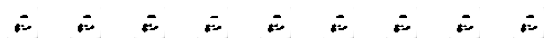

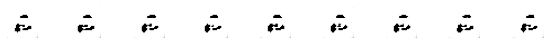

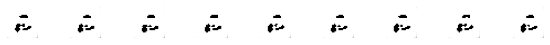

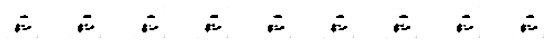

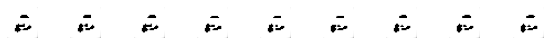

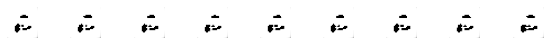

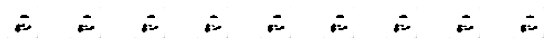

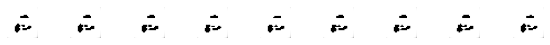

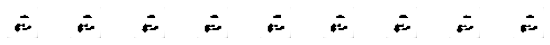

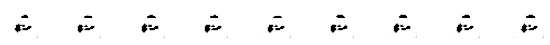

Epoch:2, Step:0, D-Loss:0.794, G-Loss:0.736
Epoch:2, Step:50, D-Loss:0.599, G-Loss:0.939
Epoch:2, Step:100, D-Loss:0.578, G-Loss:0.955
Epoch:2, Step:150, D-Loss:0.489, G-Loss:1.126
Epoch:2, Step:200, D-Loss:0.576, G-Loss:0.966
Epoch:2, Step:250, D-Loss:0.669, G-Loss:1.026
Epoch:2, Step:300, D-Loss:0.947, G-Loss:0.335
Epoch:2, Step:350, D-Loss:0.662, G-Loss:0.776
Epoch:2, Step:400, D-Loss:0.690, G-Loss:0.747
Epoch:2, Step:450, D-Loss:0.763, G-Loss:0.611
Epoch:3, Step:0, D-Loss:0.696, G-Loss:0.837
Epoch:3, Step:50, D-Loss:0.573, G-Loss:1.117
Epoch:3, Step:100, D-Loss:0.687, G-Loss:0.774
Epoch:3, Step:150, D-Loss:0.766, G-Loss:0.640
Epoch:3, Step:200, D-Loss:0.635, G-Loss:0.782
Epoch:3, Step:250, D-Loss:0.684, G-Loss:0.758
Epoch:3, Step:300, D-Loss:0.588, G-Loss:0.906
Epoch:3, Step:350, D-Loss:0.635, G-Loss:0.825
Epoch:3, Step:400, D-Loss:0.698, G-Loss:0.753
Epoch:3, Step:450, D-Loss:0.650, G-Loss:0.791


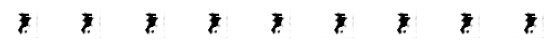

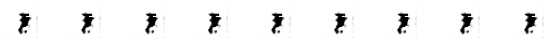

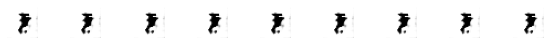

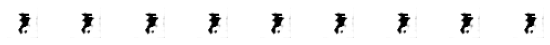

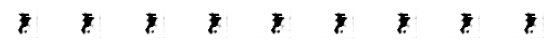

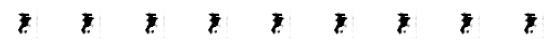

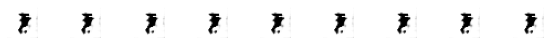

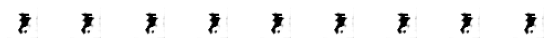

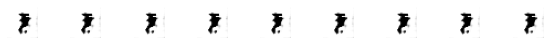

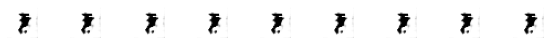

Epoch:4, Step:0, D-Loss:0.742, G-Loss:0.685
Epoch:4, Step:50, D-Loss:0.651, G-Loss:0.623
Epoch:4, Step:100, D-Loss:0.507, G-Loss:1.023
Epoch:4, Step:150, D-Loss:0.719, G-Loss:0.731
Epoch:4, Step:200, D-Loss:0.514, G-Loss:1.070
Epoch:4, Step:250, D-Loss:0.720, G-Loss:0.712
Epoch:4, Step:300, D-Loss:0.633, G-Loss:0.598
Epoch:4, Step:350, D-Loss:0.549, G-Loss:1.005
Epoch:4, Step:400, D-Loss:0.808, G-Loss:0.760
Epoch:4, Step:450, D-Loss:0.431, G-Loss:1.193
Epoch:5, Step:0, D-Loss:1.030, G-Loss:0.356
Epoch:5, Step:50, D-Loss:0.769, G-Loss:0.671
Epoch:5, Step:100, D-Loss:0.822, G-Loss:0.611
Epoch:5, Step:150, D-Loss:0.650, G-Loss:0.715
Epoch:5, Step:200, D-Loss:0.695, G-Loss:0.924
Epoch:5, Step:250, D-Loss:0.541, G-Loss:1.157
Epoch:5, Step:300, D-Loss:0.674, G-Loss:0.861
Epoch:5, Step:350, D-Loss:0.514, G-Loss:1.308
Epoch:5, Step:400, D-Loss:0.859, G-Loss:0.689
Epoch:5, Step:450, D-Loss:0.676, G-Loss:0.699


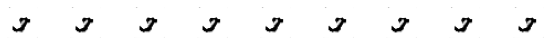

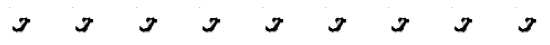

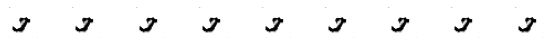

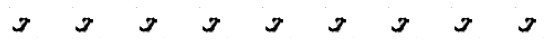

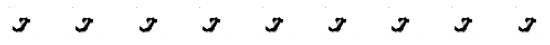

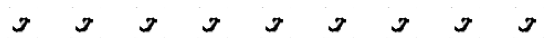

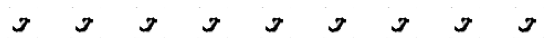

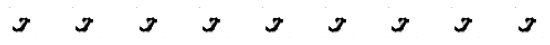

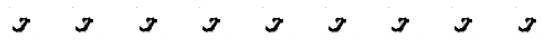

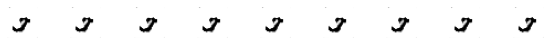

Epoch:6, Step:0, D-Loss:0.475, G-Loss:0.855
Epoch:6, Step:50, D-Loss:0.572, G-Loss:0.957
Epoch:6, Step:100, D-Loss:0.672, G-Loss:0.665
Epoch:6, Step:150, D-Loss:0.578, G-Loss:0.992
Epoch:6, Step:200, D-Loss:1.645, G-Loss:0.214
Epoch:6, Step:250, D-Loss:0.718, G-Loss:0.972
Epoch:6, Step:300, D-Loss:0.679, G-Loss:0.797
Epoch:6, Step:350, D-Loss:0.437, G-Loss:1.049
Epoch:6, Step:400, D-Loss:0.528, G-Loss:0.831
Epoch:6, Step:450, D-Loss:0.383, G-Loss:0.945
Epoch:7, Step:0, D-Loss:0.815, G-Loss:0.911
Epoch:7, Step:50, D-Loss:0.460, G-Loss:0.880
Epoch:7, Step:100, D-Loss:0.476, G-Loss:1.477
Epoch:7, Step:150, D-Loss:0.445, G-Loss:1.114
Epoch:7, Step:200, D-Loss:0.593, G-Loss:1.416
Epoch:7, Step:250, D-Loss:0.501, G-Loss:1.519
Epoch:7, Step:300, D-Loss:0.687, G-Loss:0.665
Epoch:7, Step:350, D-Loss:0.647, G-Loss:1.255
Epoch:7, Step:400, D-Loss:0.204, G-Loss:2.039
Epoch:7, Step:450, D-Loss:0.495, G-Loss:1.652


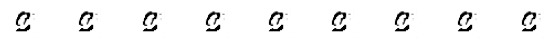

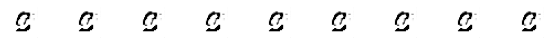

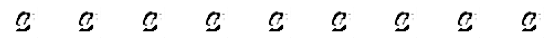

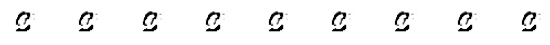

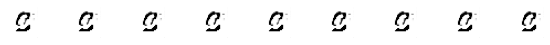

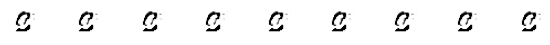

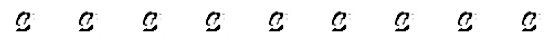

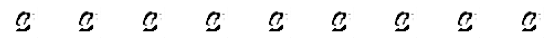

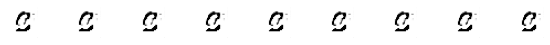

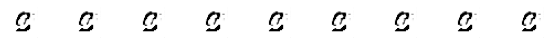

Epoch:8, Step:0, D-Loss:0.456, G-Loss:0.832
Epoch:8, Step:50, D-Loss:0.416, G-Loss:0.755
Epoch:8, Step:100, D-Loss:0.468, G-Loss:1.209
Epoch:8, Step:150, D-Loss:0.297, G-Loss:2.081
Epoch:8, Step:200, D-Loss:0.449, G-Loss:1.987
Epoch:8, Step:250, D-Loss:0.591, G-Loss:1.404
Epoch:8, Step:300, D-Loss:0.684, G-Loss:0.627
Epoch:8, Step:350, D-Loss:0.148, G-Loss:3.061
Epoch:8, Step:400, D-Loss:0.003, G-Loss:7.226
Epoch:8, Step:450, D-Loss:0.000, G-Loss:11.293
Epoch:9, Step:0, D-Loss:3.970, G-Loss:0.012
Epoch:9, Step:50, D-Loss:0.671, G-Loss:2.041
Epoch:9, Step:100, D-Loss:0.738, G-Loss:0.739
Epoch:9, Step:150, D-Loss:0.622, G-Loss:0.529
Epoch:9, Step:200, D-Loss:0.566, G-Loss:0.622
Epoch:9, Step:250, D-Loss:0.454, G-Loss:0.741
Epoch:9, Step:300, D-Loss:0.199, G-Loss:1.454
Epoch:9, Step:350, D-Loss:0.405, G-Loss:2.342
Epoch:9, Step:400, D-Loss:0.534, G-Loss:1.832
Epoch:9, Step:450, D-Loss:0.774, G-Loss:1.374


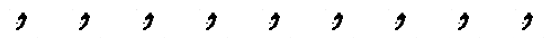

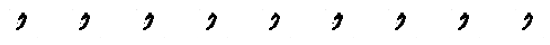

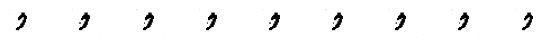

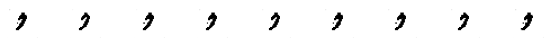

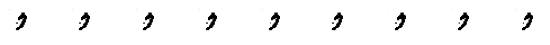

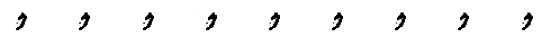

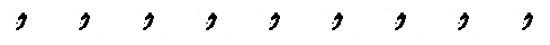

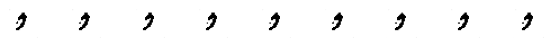

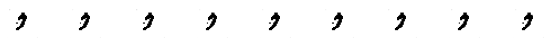

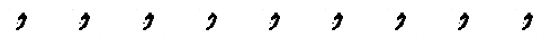

Epoch:10, Step:0, D-Loss:0.259, G-Loss:1.132
Epoch:10, Step:50, D-Loss:0.731, G-Loss:1.499
Epoch:10, Step:100, D-Loss:0.493, G-Loss:1.191
Epoch:10, Step:150, D-Loss:0.287, G-Loss:0.956
Epoch:10, Step:200, D-Loss:0.493, G-Loss:1.931
Epoch:10, Step:250, D-Loss:0.417, G-Loss:2.528
Epoch:10, Step:300, D-Loss:0.210, G-Loss:3.038
Epoch:10, Step:350, D-Loss:0.614, G-Loss:1.262
Epoch:10, Step:400, D-Loss:0.454, G-Loss:2.095
Epoch:10, Step:450, D-Loss:0.054, G-Loss:4.646
Epoch:11, Step:0, D-Loss:0.353, G-Loss:0.906
Epoch:11, Step:50, D-Loss:0.643, G-Loss:0.457
Epoch:11, Step:100, D-Loss:0.453, G-Loss:0.610
Epoch:11, Step:150, D-Loss:0.498, G-Loss:0.913
Epoch:11, Step:200, D-Loss:0.524, G-Loss:1.443
Epoch:11, Step:250, D-Loss:0.460, G-Loss:1.306
Epoch:11, Step:300, D-Loss:0.491, G-Loss:1.191
Epoch:11, Step:350, D-Loss:0.425, G-Loss:0.752
Epoch:11, Step:400, D-Loss:0.633, G-Loss:0.476
Epoch:11, Step:450, D-Loss:0.514, G-Loss:0.601


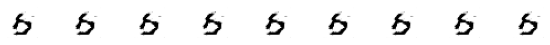

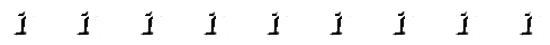

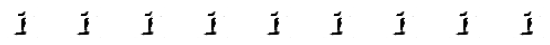

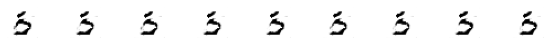

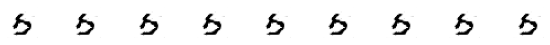

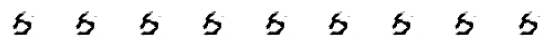

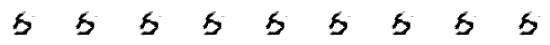

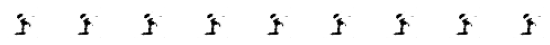

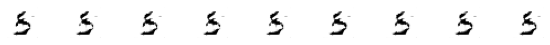

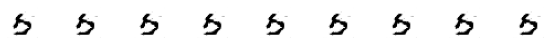

Epoch:12, Step:0, D-Loss:0.555, G-Loss:0.598
Epoch:12, Step:50, D-Loss:0.546, G-Loss:0.826
Epoch:12, Step:100, D-Loss:0.772, G-Loss:0.455
Epoch:12, Step:150, D-Loss:0.733, G-Loss:0.474
Epoch:12, Step:200, D-Loss:0.758, G-Loss:0.446
Epoch:12, Step:250, D-Loss:0.740, G-Loss:0.406
Epoch:12, Step:300, D-Loss:0.838, G-Loss:0.354
Epoch:12, Step:350, D-Loss:0.745, G-Loss:0.422
Epoch:12, Step:400, D-Loss:0.704, G-Loss:0.386
Epoch:12, Step:450, D-Loss:0.795, G-Loss:0.417
Epoch:13, Step:0, D-Loss:0.812, G-Loss:0.429
Epoch:13, Step:50, D-Loss:0.903, G-Loss:0.416
Epoch:13, Step:100, D-Loss:0.864, G-Loss:0.368
Epoch:13, Step:150, D-Loss:0.839, G-Loss:0.414
Epoch:13, Step:200, D-Loss:0.837, G-Loss:0.473
Epoch:13, Step:250, D-Loss:0.814, G-Loss:0.488
Epoch:13, Step:300, D-Loss:0.786, G-Loss:0.506
Epoch:13, Step:350, D-Loss:0.819, G-Loss:0.471
Epoch:13, Step:400, D-Loss:0.775, G-Loss:0.425
Epoch:13, Step:450, D-Loss:0.841, G-Loss:0.433


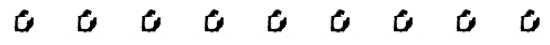

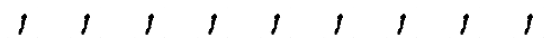

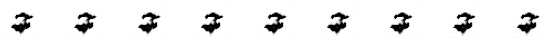

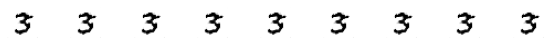

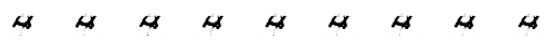

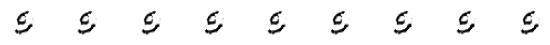

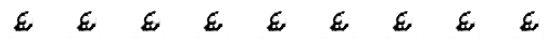

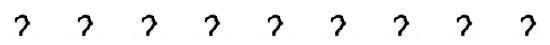

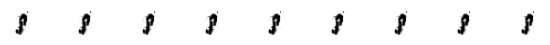

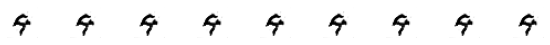

Epoch:14, Step:0, D-Loss:0.790, G-Loss:0.424
Epoch:14, Step:50, D-Loss:0.783, G-Loss:0.441
Epoch:14, Step:100, D-Loss:0.799, G-Loss:0.503
Epoch:14, Step:150, D-Loss:0.784, G-Loss:0.468
Epoch:14, Step:200, D-Loss:0.747, G-Loss:0.461
Epoch:14, Step:250, D-Loss:0.735, G-Loss:0.477
Epoch:14, Step:300, D-Loss:0.781, G-Loss:0.425
Epoch:14, Step:350, D-Loss:0.768, G-Loss:0.467
Epoch:14, Step:400, D-Loss:0.753, G-Loss:0.569
Epoch:14, Step:450, D-Loss:0.743, G-Loss:0.498
Epoch:15, Step:0, D-Loss:0.720, G-Loss:0.558
Epoch:15, Step:50, D-Loss:0.729, G-Loss:0.548
Epoch:15, Step:100, D-Loss:0.749, G-Loss:0.480
Epoch:15, Step:150, D-Loss:0.720, G-Loss:0.475
Epoch:15, Step:200, D-Loss:0.725, G-Loss:0.525
Epoch:15, Step:250, D-Loss:0.709, G-Loss:0.514
Epoch:15, Step:300, D-Loss:0.626, G-Loss:0.573
Epoch:15, Step:350, D-Loss:0.748, G-Loss:0.510
Epoch:15, Step:400, D-Loss:0.753, G-Loss:0.541
Epoch:15, Step:450, D-Loss:0.792, G-Loss:0.495


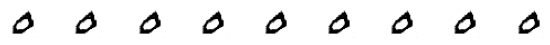

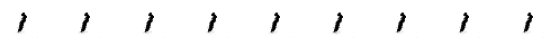

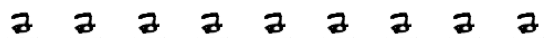

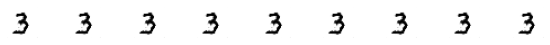

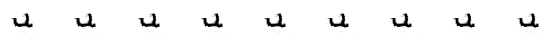

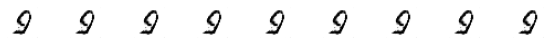

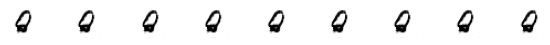

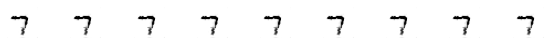

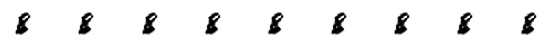

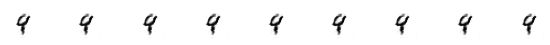

Epoch:16, Step:0, D-Loss:0.726, G-Loss:0.518
Epoch:16, Step:50, D-Loss:0.726, G-Loss:0.532
Epoch:16, Step:100, D-Loss:0.726, G-Loss:0.542
Epoch:16, Step:150, D-Loss:0.736, G-Loss:0.536
Epoch:16, Step:200, D-Loss:0.717, G-Loss:0.513
Epoch:16, Step:250, D-Loss:0.753, G-Loss:0.529
Epoch:16, Step:300, D-Loss:0.748, G-Loss:0.547
Epoch:16, Step:350, D-Loss:0.746, G-Loss:0.558
Epoch:16, Step:400, D-Loss:0.810, G-Loss:0.461
Epoch:16, Step:450, D-Loss:0.779, G-Loss:0.511
Epoch:17, Step:0, D-Loss:0.734, G-Loss:0.481
Epoch:17, Step:50, D-Loss:0.789, G-Loss:0.505
Epoch:17, Step:100, D-Loss:0.726, G-Loss:0.524
Epoch:17, Step:150, D-Loss:0.752, G-Loss:0.493
Epoch:17, Step:200, D-Loss:0.769, G-Loss:0.511
Epoch:17, Step:250, D-Loss:0.743, G-Loss:0.489
Epoch:17, Step:300, D-Loss:0.733, G-Loss:0.526
Epoch:17, Step:350, D-Loss:0.717, G-Loss:0.541
Epoch:17, Step:400, D-Loss:0.733, G-Loss:0.548
Epoch:17, Step:450, D-Loss:0.703, G-Loss:0.505


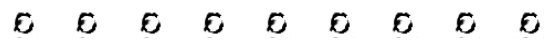

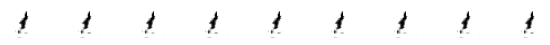

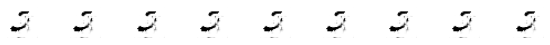

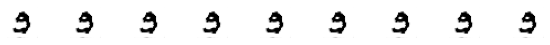

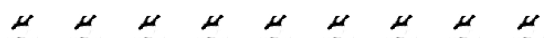

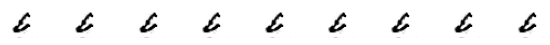

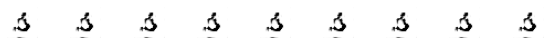

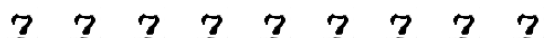

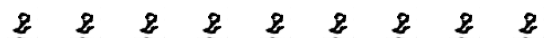

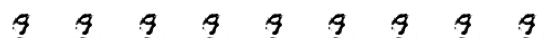

Epoch:18, Step:0, D-Loss:0.695, G-Loss:0.515
Epoch:18, Step:50, D-Loss:0.692, G-Loss:0.527
Epoch:18, Step:100, D-Loss:0.746, G-Loss:0.551
Epoch:18, Step:150, D-Loss:0.693, G-Loss:0.546
Epoch:18, Step:200, D-Loss:0.679, G-Loss:0.544
Epoch:18, Step:250, D-Loss:0.647, G-Loss:0.642
Epoch:18, Step:300, D-Loss:0.706, G-Loss:0.555
Epoch:18, Step:350, D-Loss:0.690, G-Loss:0.528
Epoch:18, Step:400, D-Loss:0.738, G-Loss:0.518
Epoch:18, Step:450, D-Loss:0.698, G-Loss:0.509
Epoch:19, Step:0, D-Loss:0.699, G-Loss:0.526
Epoch:19, Step:50, D-Loss:0.721, G-Loss:0.602
Epoch:19, Step:100, D-Loss:0.733, G-Loss:0.543
Epoch:19, Step:150, D-Loss:0.696, G-Loss:0.542
Epoch:19, Step:200, D-Loss:0.708, G-Loss:0.548
Epoch:19, Step:250, D-Loss:0.690, G-Loss:0.557
Epoch:19, Step:300, D-Loss:0.707, G-Loss:0.553
Epoch:19, Step:350, D-Loss:0.678, G-Loss:0.543
Epoch:19, Step:400, D-Loss:0.695, G-Loss:0.552
Epoch:19, Step:450, D-Loss:0.714, G-Loss:0.567


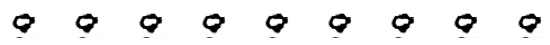

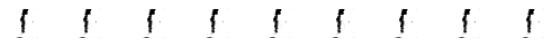

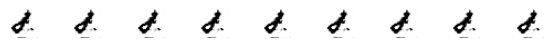

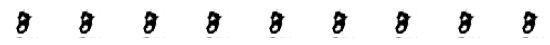

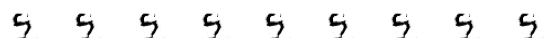

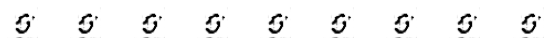

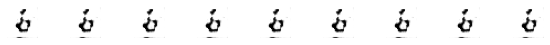

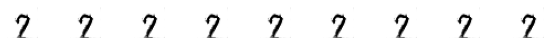

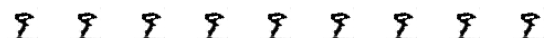

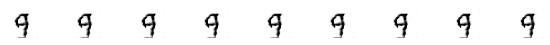

Epoch:20, Step:0, D-Loss:0.684, G-Loss:0.639
Epoch:20, Step:50, D-Loss:0.706, G-Loss:0.595
Epoch:20, Step:100, D-Loss:0.704, G-Loss:0.519
Epoch:20, Step:150, D-Loss:0.750, G-Loss:0.524
Epoch:20, Step:200, D-Loss:0.691, G-Loss:0.610
Epoch:20, Step:250, D-Loss:0.687, G-Loss:0.537
Epoch:20, Step:300, D-Loss:0.694, G-Loss:0.561
Epoch:20, Step:350, D-Loss:0.724, G-Loss:0.557
Epoch:20, Step:400, D-Loss:0.694, G-Loss:0.561
Epoch:20, Step:450, D-Loss:0.680, G-Loss:0.541
Epoch:21, Step:0, D-Loss:0.652, G-Loss:0.583
Epoch:21, Step:50, D-Loss:0.703, G-Loss:0.557
Epoch:21, Step:100, D-Loss:0.678, G-Loss:0.553
Epoch:21, Step:150, D-Loss:0.727, G-Loss:0.519
Epoch:21, Step:200, D-Loss:0.718, G-Loss:0.543
Epoch:21, Step:250, D-Loss:0.674, G-Loss:0.583
Epoch:21, Step:300, D-Loss:0.703, G-Loss:0.641
Epoch:21, Step:350, D-Loss:0.714, G-Loss:0.534
Epoch:21, Step:400, D-Loss:0.724, G-Loss:0.517
Epoch:21, Step:450, D-Loss:0.691, G-Loss:0.556


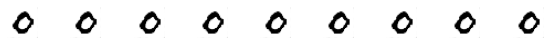

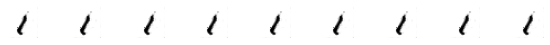

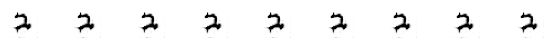

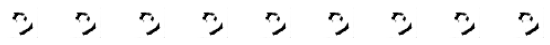

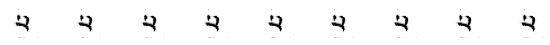

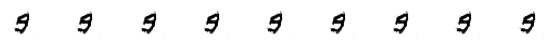

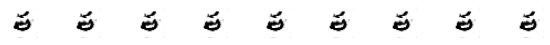

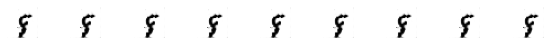

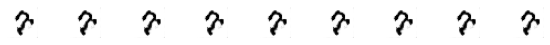

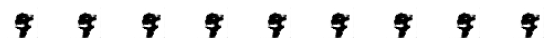

Epoch:22, Step:0, D-Loss:0.736, G-Loss:0.558
Epoch:22, Step:50, D-Loss:0.708, G-Loss:0.535
Epoch:22, Step:100, D-Loss:0.722, G-Loss:0.561
Epoch:22, Step:150, D-Loss:0.675, G-Loss:0.590
Epoch:22, Step:200, D-Loss:0.703, G-Loss:0.578
Epoch:22, Step:250, D-Loss:0.712, G-Loss:0.532
Epoch:22, Step:300, D-Loss:0.727, G-Loss:0.572
Epoch:22, Step:350, D-Loss:0.706, G-Loss:0.548
Epoch:22, Step:400, D-Loss:0.712, G-Loss:0.566
Epoch:22, Step:450, D-Loss:0.691, G-Loss:0.550
Epoch:23, Step:0, D-Loss:0.719, G-Loss:0.595
Epoch:23, Step:50, D-Loss:0.724, G-Loss:0.579
Epoch:23, Step:100, D-Loss:0.711, G-Loss:0.560
Epoch:23, Step:150, D-Loss:0.730, G-Loss:0.561
Epoch:23, Step:200, D-Loss:0.726, G-Loss:0.577
Epoch:23, Step:250, D-Loss:0.709, G-Loss:0.551
Epoch:23, Step:300, D-Loss:0.719, G-Loss:0.580
Epoch:23, Step:350, D-Loss:0.684, G-Loss:0.596
Epoch:23, Step:400, D-Loss:0.701, G-Loss:0.615
Epoch:23, Step:450, D-Loss:0.690, G-Loss:0.598


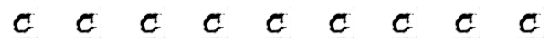

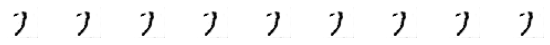

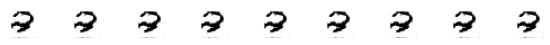

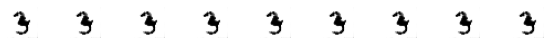

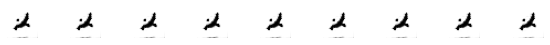

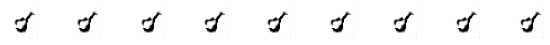

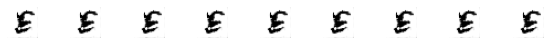

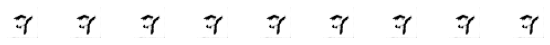

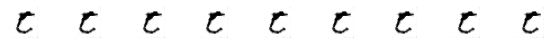

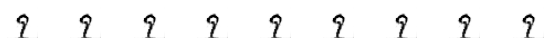

Epoch:24, Step:0, D-Loss:0.680, G-Loss:0.633
Epoch:24, Step:50, D-Loss:0.687, G-Loss:0.579
Epoch:24, Step:100, D-Loss:0.704, G-Loss:0.558
Epoch:24, Step:150, D-Loss:0.692, G-Loss:0.619
Epoch:24, Step:200, D-Loss:0.686, G-Loss:0.621
Epoch:24, Step:250, D-Loss:0.681, G-Loss:0.633
Epoch:24, Step:300, D-Loss:0.679, G-Loss:0.605
Epoch:24, Step:350, D-Loss:0.655, G-Loss:0.615
Epoch:24, Step:400, D-Loss:0.648, G-Loss:0.607
Epoch:24, Step:450, D-Loss:0.724, G-Loss:0.579
Epoch:25, Step:0, D-Loss:0.673, G-Loss:0.631
Epoch:25, Step:50, D-Loss:0.723, G-Loss:0.657
Epoch:25, Step:100, D-Loss:0.689, G-Loss:0.620
Epoch:25, Step:150, D-Loss:0.692, G-Loss:0.606
Epoch:25, Step:200, D-Loss:0.701, G-Loss:0.599
Epoch:25, Step:250, D-Loss:0.662, G-Loss:0.586
Epoch:25, Step:300, D-Loss:0.706, G-Loss:0.586
Epoch:25, Step:350, D-Loss:0.681, G-Loss:0.564
Epoch:25, Step:400, D-Loss:0.705, G-Loss:0.590
Epoch:25, Step:450, D-Loss:0.679, G-Loss:0.616


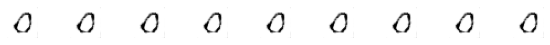

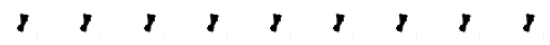

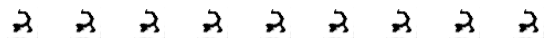

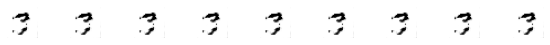

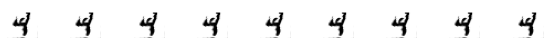

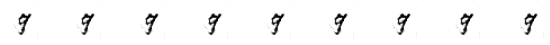

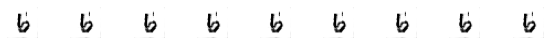

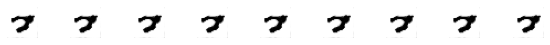

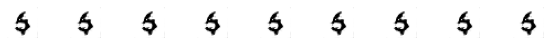

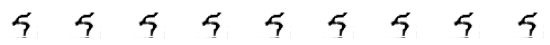

Epoch:26, Step:0, D-Loss:0.676, G-Loss:0.607
Epoch:26, Step:50, D-Loss:0.679, G-Loss:0.610
Epoch:26, Step:100, D-Loss:0.693, G-Loss:0.589
Epoch:26, Step:150, D-Loss:0.678, G-Loss:0.599
Epoch:26, Step:200, D-Loss:0.699, G-Loss:0.585
Epoch:26, Step:250, D-Loss:0.675, G-Loss:0.584
Epoch:26, Step:300, D-Loss:0.658, G-Loss:0.875
Epoch:26, Step:350, D-Loss:0.703, G-Loss:0.825
Epoch:26, Step:400, D-Loss:0.712, G-Loss:0.844
Epoch:26, Step:450, D-Loss:0.680, G-Loss:0.842
Epoch:27, Step:0, D-Loss:0.698, G-Loss:0.901
Epoch:27, Step:50, D-Loss:0.674, G-Loss:0.877
Epoch:27, Step:100, D-Loss:0.699, G-Loss:0.908
Epoch:27, Step:150, D-Loss:0.653, G-Loss:0.881
Epoch:27, Step:200, D-Loss:0.671, G-Loss:0.905
Epoch:27, Step:250, D-Loss:0.682, G-Loss:0.905
Epoch:27, Step:300, D-Loss:0.681, G-Loss:0.890
Epoch:27, Step:350, D-Loss:0.661, G-Loss:0.897
Epoch:27, Step:400, D-Loss:0.661, G-Loss:0.891
Epoch:27, Step:450, D-Loss:0.671, G-Loss:0.899


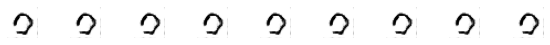

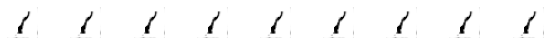

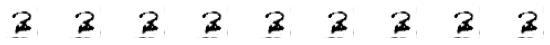

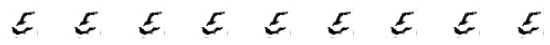

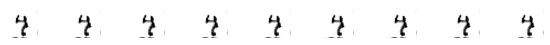

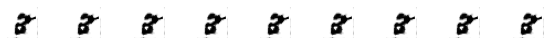

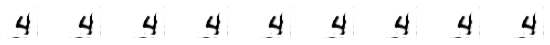

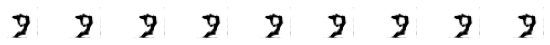

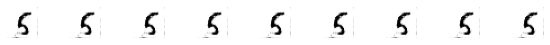

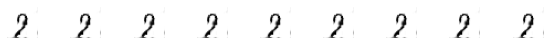

Epoch:28, Step:0, D-Loss:0.713, G-Loss:0.854
Epoch:28, Step:50, D-Loss:0.718, G-Loss:0.857
Epoch:28, Step:100, D-Loss:0.698, G-Loss:0.823
Epoch:28, Step:150, D-Loss:0.690, G-Loss:0.872
Epoch:28, Step:200, D-Loss:0.671, G-Loss:0.866
Epoch:28, Step:250, D-Loss:0.720, G-Loss:0.883
Epoch:28, Step:300, D-Loss:0.688, G-Loss:0.821
Epoch:28, Step:350, D-Loss:0.690, G-Loss:0.858
Epoch:28, Step:400, D-Loss:0.674, G-Loss:0.889
Epoch:28, Step:450, D-Loss:0.712, G-Loss:0.848
Epoch:29, Step:0, D-Loss:0.674, G-Loss:0.862
Epoch:29, Step:50, D-Loss:0.691, G-Loss:0.861
Epoch:29, Step:100, D-Loss:0.690, G-Loss:0.889
Epoch:29, Step:150, D-Loss:0.691, G-Loss:0.855
Epoch:29, Step:200, D-Loss:0.690, G-Loss:0.847
Epoch:29, Step:250, D-Loss:0.659, G-Loss:0.886
Epoch:29, Step:300, D-Loss:0.685, G-Loss:0.864
Epoch:29, Step:350, D-Loss:0.690, G-Loss:0.876
Epoch:29, Step:400, D-Loss:0.702, G-Loss:0.839
Epoch:29, Step:450, D-Loss:0.720, G-Loss:0.591


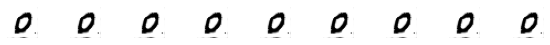

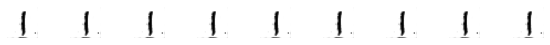

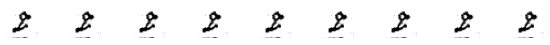

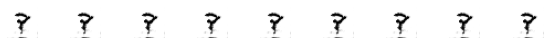

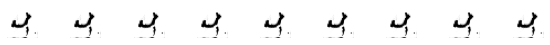

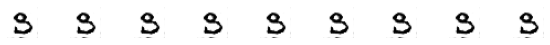

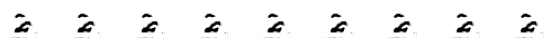

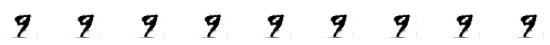

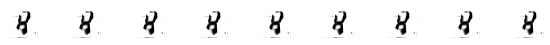

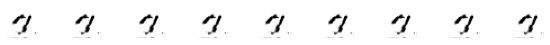

Epoch:30, Step:0, D-Loss:0.684, G-Loss:0.610
Epoch:30, Step:50, D-Loss:0.690, G-Loss:0.606
Epoch:30, Step:100, D-Loss:0.716, G-Loss:0.634
Epoch:30, Step:150, D-Loss:0.661, G-Loss:0.665
Epoch:30, Step:200, D-Loss:0.674, G-Loss:0.654
Epoch:30, Step:250, D-Loss:0.721, G-Loss:0.595
Epoch:30, Step:300, D-Loss:0.709, G-Loss:0.618
Epoch:30, Step:350, D-Loss:0.702, G-Loss:0.596
Epoch:30, Step:400, D-Loss:0.679, G-Loss:0.647
Epoch:30, Step:450, D-Loss:0.666, G-Loss:0.660
Epoch:31, Step:0, D-Loss:0.709, G-Loss:0.621
Epoch:31, Step:50, D-Loss:0.710, G-Loss:0.598
Epoch:31, Step:100, D-Loss:0.702, G-Loss:0.597
Epoch:31, Step:150, D-Loss:0.703, G-Loss:0.619
Epoch:31, Step:200, D-Loss:0.726, G-Loss:0.624
Epoch:31, Step:250, D-Loss:0.672, G-Loss:0.656
Epoch:31, Step:300, D-Loss:0.699, G-Loss:0.600
Epoch:31, Step:350, D-Loss:0.713, G-Loss:0.592
Epoch:31, Step:400, D-Loss:0.686, G-Loss:0.623
Epoch:31, Step:450, D-Loss:0.689, G-Loss:0.836


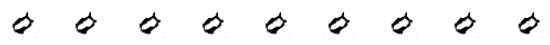

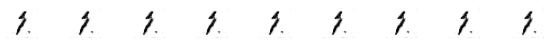

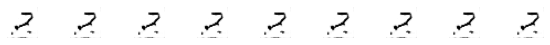

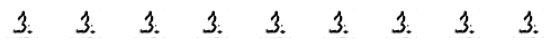

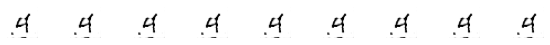

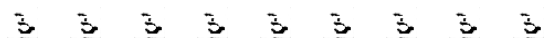

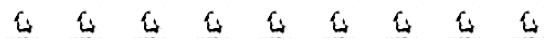

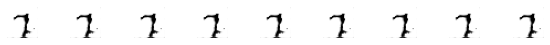

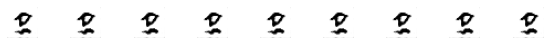

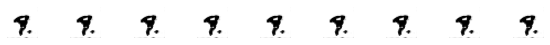

Epoch:32, Step:0, D-Loss:0.685, G-Loss:0.818
Epoch:32, Step:50, D-Loss:0.681, G-Loss:0.860
Epoch:32, Step:100, D-Loss:0.691, G-Loss:0.854
Epoch:32, Step:150, D-Loss:0.684, G-Loss:0.596
Epoch:32, Step:200, D-Loss:0.715, G-Loss:0.628
Epoch:32, Step:250, D-Loss:0.710, G-Loss:0.609
Epoch:32, Step:300, D-Loss:0.679, G-Loss:0.644
Epoch:32, Step:350, D-Loss:0.701, G-Loss:0.608
Epoch:32, Step:400, D-Loss:0.664, G-Loss:0.824
Epoch:32, Step:450, D-Loss:0.671, G-Loss:0.844
Epoch:33, Step:0, D-Loss:0.696, G-Loss:0.882
Epoch:33, Step:50, D-Loss:0.707, G-Loss:0.840
Epoch:33, Step:100, D-Loss:0.663, G-Loss:0.858
Epoch:33, Step:150, D-Loss:0.709, G-Loss:0.819
Epoch:33, Step:200, D-Loss:0.683, G-Loss:0.883
Epoch:33, Step:250, D-Loss:0.658, G-Loss:0.931
Epoch:33, Step:300, D-Loss:0.663, G-Loss:0.875
Epoch:33, Step:350, D-Loss:0.681, G-Loss:0.861
Epoch:33, Step:400, D-Loss:0.655, G-Loss:0.860
Epoch:33, Step:450, D-Loss:0.683, G-Loss:0.822


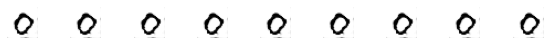

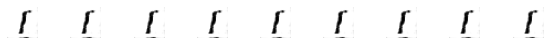

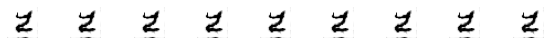

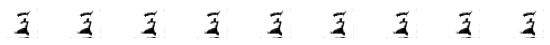

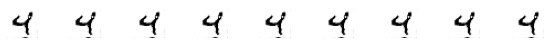

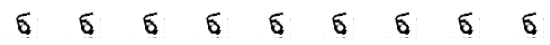

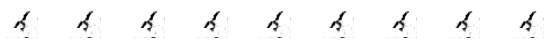

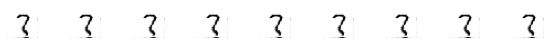

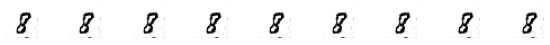

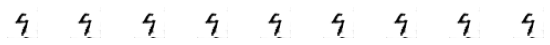

Epoch:34, Step:0, D-Loss:0.709, G-Loss:0.823
Epoch:34, Step:50, D-Loss:0.691, G-Loss:0.842
Epoch:34, Step:100, D-Loss:0.698, G-Loss:0.862
Epoch:34, Step:150, D-Loss:0.677, G-Loss:0.846
Epoch:34, Step:200, D-Loss:0.711, G-Loss:0.787
Epoch:34, Step:250, D-Loss:0.670, G-Loss:0.835
Epoch:34, Step:300, D-Loss:0.683, G-Loss:0.857
Epoch:34, Step:350, D-Loss:0.681, G-Loss:0.851
Epoch:34, Step:400, D-Loss:0.693, G-Loss:0.881
Epoch:34, Step:450, D-Loss:0.693, G-Loss:0.887
Epoch:35, Step:0, D-Loss:0.675, G-Loss:0.867
Epoch:35, Step:50, D-Loss:0.701, G-Loss:0.867
Epoch:35, Step:100, D-Loss:0.720, G-Loss:0.816
Epoch:35, Step:150, D-Loss:0.707, G-Loss:0.794
Epoch:35, Step:200, D-Loss:0.691, G-Loss:0.814
Epoch:35, Step:250, D-Loss:0.680, G-Loss:0.813
Epoch:35, Step:300, D-Loss:0.686, G-Loss:0.809
Epoch:35, Step:350, D-Loss:0.715, G-Loss:0.829
Epoch:35, Step:400, D-Loss:0.651, G-Loss:0.871
Epoch:35, Step:450, D-Loss:0.659, G-Loss:0.893


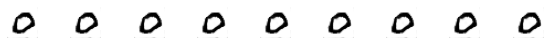

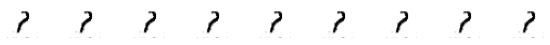

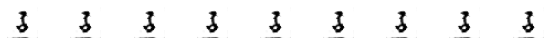

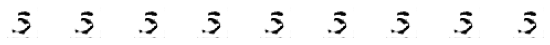

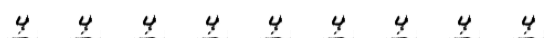

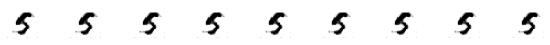

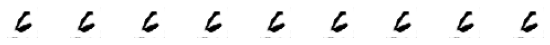

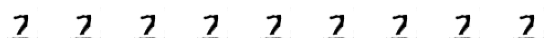

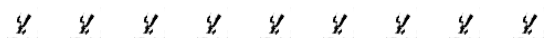

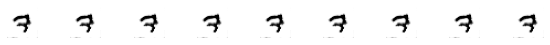

Epoch:36, Step:0, D-Loss:0.686, G-Loss:0.627
Epoch:36, Step:50, D-Loss:0.719, G-Loss:0.841
Epoch:36, Step:100, D-Loss:0.689, G-Loss:0.822
Epoch:36, Step:150, D-Loss:0.672, G-Loss:0.857
Epoch:36, Step:200, D-Loss:0.704, G-Loss:0.824
Epoch:36, Step:250, D-Loss:0.692, G-Loss:0.831
Epoch:36, Step:300, D-Loss:0.701, G-Loss:0.794
Epoch:36, Step:350, D-Loss:0.662, G-Loss:0.862
Epoch:36, Step:400, D-Loss:0.682, G-Loss:0.865
Epoch:36, Step:450, D-Loss:0.685, G-Loss:0.827
Epoch:37, Step:0, D-Loss:0.662, G-Loss:0.841
Epoch:37, Step:50, D-Loss:0.662, G-Loss:0.854
Epoch:37, Step:100, D-Loss:0.708, G-Loss:0.753
Epoch:37, Step:150, D-Loss:0.685, G-Loss:0.652
Epoch:37, Step:200, D-Loss:0.651, G-Loss:0.638
Epoch:37, Step:250, D-Loss:0.699, G-Loss:0.645
Epoch:37, Step:300, D-Loss:0.691, G-Loss:0.602
Epoch:37, Step:350, D-Loss:0.672, G-Loss:0.610
Epoch:37, Step:400, D-Loss:0.650, G-Loss:0.630
Epoch:37, Step:450, D-Loss:0.699, G-Loss:0.630


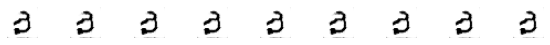

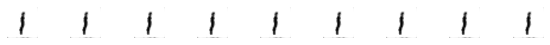

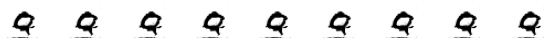

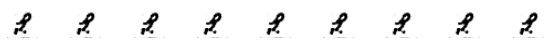

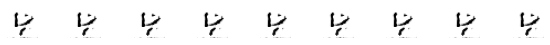

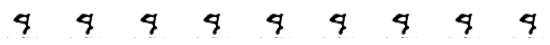

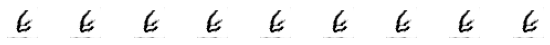

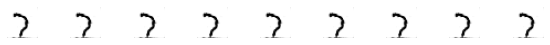

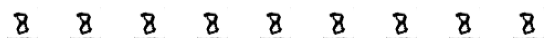

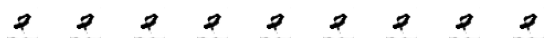

Epoch:38, Step:0, D-Loss:0.675, G-Loss:0.605


KeyboardInterrupt: ignored

In [ ]:
epochs = 100
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%2 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)     # get fake samples
        real_samples = get_real_samples(batch_size=batch_size//2)                            # get real samples

        fake_y = np.zeros((batch_size//2, 1))              # 0 for fake
        real_y = np.ones((batch_size//2, 1))                  # 1 for real
        
        input_batch_part1 = np.vstack((fake_samples[0], real_samples[0]))
        input_batch_part2 = np.vstack((fake_samples[1], real_samples[1]))
        
        input_batch_final = [input_batch_part1, input_batch_part2]
        
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        #discriminator_network.trainable=True
        #loss_d = discriminator_network.train_on_batch(input_batch_final, output_labels)
        
        with tf.GradientTape() as tape:
            dis_output = discriminator_network(input_batch_final)   # input_batch_final is each batch
            loss_d = tf.keras.losses.BinaryCrossentropy()(output_labels, dis_output)

        grads = tape.gradient(loss_d, discriminator_network.trainable_weights)

        d_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
        d_optimizer.apply_gradients(zip(grads, discriminator_network.trainable_weights))
        
        noise_batches, class_values = get_random_noise(batch_size, noise_size)     # get random vector
        gan_input = [noise_batches, class_values]                 
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = tensorflow.ones((batch_size, 1))                     # to fool discrimanator to output 1
        
        # Updating Generator weights
      
        #discriminator_network.trainable=False
        #loss_g = gan_model.train_on_batch(gan_input, gan_output)
        
        with tf.GradientTape() as tape:
            gen_output = generator_network(gan_input)
            dis_output = discriminator_network([gen_output, class_values])
            loss_g = tf.keras.losses.BinaryCrossentropy()(gan_output, dis_output)

        grads = tape.gradient(loss_g, generator_network.trainable_weights)
        
        g_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)
        g_optimizer.apply_gradients(zip(grads, generator_network.trainable_weights))
        
        # for train_on_bath():
        #if j%50 == 0:
            #print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))
         
        # for gradientTape:
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, G-Loss:%.3f"%(i, j, loss_d, loss_g))

In summary, a stable GAN will have a discriminator loss around 0.5, typically between 0.5 and maybe as high as 0.7 or 0.8. The generator loss is typically higher and may hover around 1.0, 1.5, 2.0, or even higher.

The accuracy of the discriminator on both real and generated (fake) images will not be 50%, but should typically hover around 70% to 80%.

For both the discriminator and generator, behaviors are likely to start off erratic and move around a lot before the model converges to a stable equilibrium.

In generative adversarial networks, the discriminator and the generator play a kind of minimax game.

### Appendix

The following compares GradientTape with [train_on_batch()](https://keras.io/api/models/model_training_apis/), which is typically used in TensorFlow Version 1 before GradientTape is released.

In [ ]:
### The tf.function
@tf.function
def train_on_batch(X, y):        # Runs a single gradient update on a single batch of data.     X, y is each batch
    with tf.GradientTape() as tape:
        ŷ = model(X, training=True)
        loss_value = loss(y, ŷ)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

@tf.function
def test_on_batch(X, y):   # Test the model on a single batch of samples.
    ŷ = model(X, training=False)
    loss_value = loss(y, ŷ)
    return loss_value


@tf.function
def predict_on_batch(X):     # Returns predictions for a single batch of samples.
    ŷ = model(X, training=False)
    return ŷ
